In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
from torchvision import transforms as T

import torch.optim as optim

from models.s8 import SkipNet
from utils import build_cifar, Trainer, plot_sampledata, plot_misclassified

# Load Data

In [3]:
# Train data transformations
train_transforms = T.Compose(
    [
        T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
        T.RandomRotation((-5.0, 5.0), fill=(0.49139968, 0.48215841, 0.44653091)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(
            (0.49139968, 0.48215841, 0.44653091),
            (0.24703223, 0.24348513, 0.26158784),
        ),
    ]
)

# Test data transformations
test_transforms = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

batch_size = 64

kwargs = {
    "batch_size": batch_size,
    "shuffle": True,
    "num_workers": 2,
    "pin_memory": True,
}

train_data, train_loader = build_cifar(set="train", transforms=train_transforms, **kwargs)
test_data, test_loader = build_cifar(set="test", transforms=test_transforms, **kwargs)

100%|██████████| 170498071/170498071 [00:02<00:00, 73438701.74it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


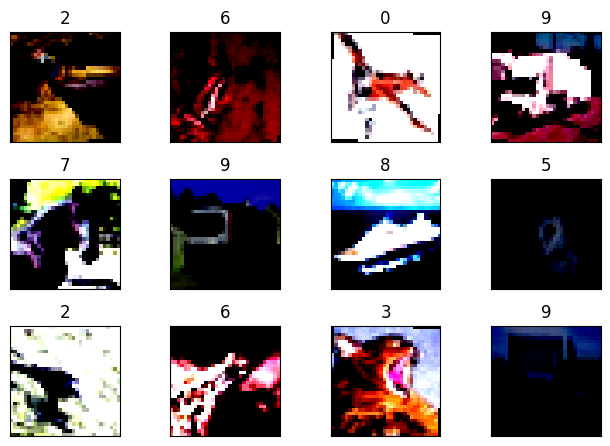

In [4]:
plot_sampledata(train_loader)

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = SkipNet(norm="ln").to(device)

In [12]:
model.summarize(device, (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
SkipNet                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 8, 32, 32]            216
│    └─ReLU: 2-2                         [1, 8, 32, 32]            --
│    └─GroupNorm: 2-3                    [1, 8, 32, 32]            16
│    └─Dropout2d: 2-4                    [1, 8, 32, 32]            --
│    └─Conv2d: 2-5                       [1, 16, 32, 32]           1,152
│    └─ReLU: 2-6                         [1, 16, 32, 32]           --
│    └─GroupNorm: 2-7                    [1, 16, 32, 32]           32
│    └─Dropout2d: 2-8                    [1, 16, 32, 32]           --
├─Sequential: 1-2                        [1, 8, 16, 16]            --
│    └─Conv2d: 2-9                       [1, 8, 32, 32]            128
│    └─ReLU: 2-10                        [1, 8, 32, 32]            --
│    └─Dro

In [13]:
num_epochs = 20
model = SkipNet(drop=0.01, norm="ln").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1, epochs=num_epochs, steps_per_epoch=len(train_loader)
)
# scheduler = None

trainer = Trainer(model, device, optimizer, scheduler)
for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}")
    trainer.train(train_loader)
    trainer.test(test_loader)

Epoch 1


Train: Loss=1.5217 Batch_id=781 Accuracy=27.36: 100%|██████████| 782/782 [00:49<00:00, 15.65it/s]


Test set: Average loss: 1.8703, Accuracy: 3199/10000 (31.99%)

Epoch 2


Train: Loss=1.8625 Batch_id=781 Accuracy=40.11: 100%|██████████| 782/782 [00:49<00:00, 15.66it/s]


Test set: Average loss: 1.5812, Accuracy: 4200/10000 (42.00%)

Epoch 3


Train: Loss=1.6227 Batch_id=781 Accuracy=46.86: 100%|██████████| 782/782 [00:51<00:00, 15.32it/s]


Test set: Average loss: 1.7080, Accuracy: 4021/10000 (40.21%)

Epoch 4


Train: Loss=0.9720 Batch_id=781 Accuracy=51.45: 100%|██████████| 782/782 [00:49<00:00, 15.73it/s]


Test set: Average loss: 1.2725, Accuracy: 5327/10000 (53.27%)

Epoch 5


Train: Loss=1.5321 Batch_id=781 Accuracy=55.21: 100%|██████████| 782/782 [00:49<00:00, 15.78it/s]


Test set: Average loss: 1.1338, Accuracy: 5994/10000 (59.94%)

Epoch 6


Train: Loss=1.1312 Batch_id=781 Accuracy=57.27: 100%|██████████| 782/782 [00:51<00:00, 15.27it/s]


Test set: Average loss: 1.1088, Accuracy: 5966/10000 (59.66%)

Epoch 7


Train: Loss=1.3460 Batch_id=781 Accuracy=59.51: 100%|██████████| 782/782 [00:50<00:00, 15.63it/s]


Test set: Average loss: 1.0686, Accuracy: 6239/10000 (62.39%)

Epoch 8


Train: Loss=0.9198 Batch_id=781 Accuracy=61.04: 100%|██████████| 782/782 [00:49<00:00, 15.64it/s]


Test set: Average loss: 1.0766, Accuracy: 6151/10000 (61.51%)

Epoch 9


Train: Loss=1.1537 Batch_id=781 Accuracy=62.46: 100%|██████████| 782/782 [00:51<00:00, 15.26it/s]


Test set: Average loss: 1.0214, Accuracy: 6371/10000 (63.71%)

Epoch 10


Train: Loss=0.6355 Batch_id=781 Accuracy=63.39: 100%|██████████| 782/782 [00:50<00:00, 15.38it/s]


Test set: Average loss: 0.9702, Accuracy: 6545/10000 (65.45%)

Epoch 11


Train: Loss=0.8224 Batch_id=781 Accuracy=64.76: 100%|██████████| 782/782 [00:51<00:00, 15.20it/s]


Test set: Average loss: 1.0185, Accuracy: 6382/10000 (63.82%)

Epoch 12


Train: Loss=0.9217 Batch_id=781 Accuracy=65.30: 100%|██████████| 782/782 [00:52<00:00, 14.98it/s]


Test set: Average loss: 0.9432, Accuracy: 6678/10000 (66.78%)

Epoch 13


Train: Loss=1.0003 Batch_id=781 Accuracy=66.57: 100%|██████████| 782/782 [00:52<00:00, 14.84it/s]


Test set: Average loss: 0.9408, Accuracy: 6633/10000 (66.33%)

Epoch 14


Train: Loss=0.7800 Batch_id=781 Accuracy=67.15: 100%|██████████| 782/782 [00:51<00:00, 15.20it/s]


Test set: Average loss: 0.8679, Accuracy: 6981/10000 (69.81%)

Epoch 15


Train: Loss=0.9560 Batch_id=781 Accuracy=68.17: 100%|██████████| 782/782 [00:51<00:00, 15.09it/s]


Test set: Average loss: 0.8637, Accuracy: 6947/10000 (69.47%)

Epoch 16


Train: Loss=0.8986 Batch_id=781 Accuracy=69.09: 100%|██████████| 782/782 [00:52<00:00, 14.93it/s]


Test set: Average loss: 0.8190, Accuracy: 7126/10000 (71.26%)

Epoch 17


Train: Loss=0.8891 Batch_id=781 Accuracy=69.94: 100%|██████████| 782/782 [00:53<00:00, 14.69it/s]


Test set: Average loss: 0.7920, Accuracy: 7239/10000 (72.39%)

Epoch 18


Train: Loss=1.0607 Batch_id=781 Accuracy=70.73: 100%|██████████| 782/782 [00:55<00:00, 13.99it/s]


Test set: Average loss: 0.7788, Accuracy: 7269/10000 (72.69%)

Epoch 19


Train: Loss=1.2026 Batch_id=781 Accuracy=71.38: 100%|██████████| 782/782 [00:52<00:00, 15.01it/s]


Test set: Average loss: 0.7773, Accuracy: 7287/10000 (72.87%)

Epoch 20


Train: Loss=0.8383 Batch_id=781 Accuracy=71.76: 100%|██████████| 782/782 [00:52<00:00, 15.03it/s]


Test set: Average loss: 0.7686, Accuracy: 7325/10000 (73.25%)



Set\t Max Acc@Epoch	 Last Epoch Acc
train	 71.76@20		71.76
test	 73.25@20		73.25


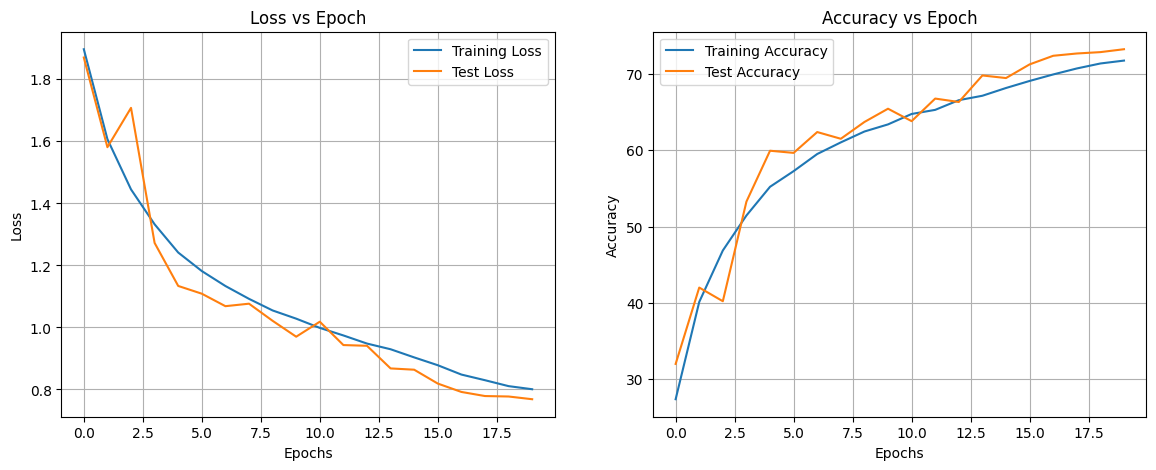

In [16]:
trainer.plot_history()

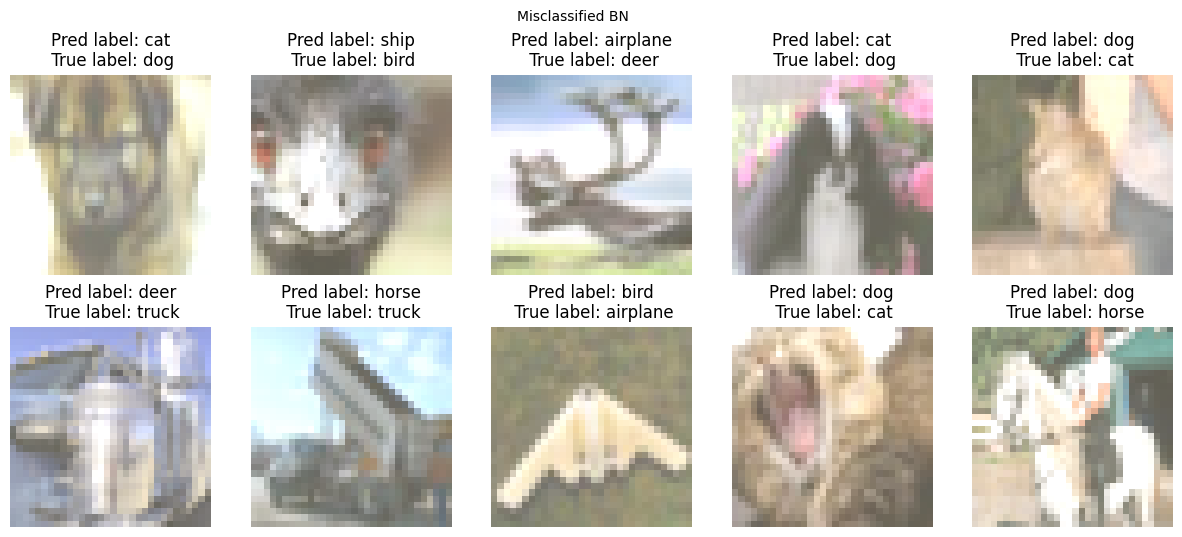

In [17]:
plot_misclassified(
    model,
    test_loader,
    device,
    (0.49139968, 0.48215841, 0.44653091),
    (0.24703223, 0.24348513, 0.26158784),
)